<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Широкоформатный Jupyter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# обновим версию sklearn
# !pip install scikit-learn --upgrade

In [3]:
# установка

!pip install imblearn
!pip3 install prettytable

!pip3 install -U spacy
!pip3 install -U spacy-lookups-data
!python3 -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 1.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
# Импортируем базы данных, которые пригодятся в нашем исследование

# импорты из стандартной библиотеки
import warnings
import re
import os

# импорты сторонних библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import torch
import transformers
from matplotlib import pyplot as plt
from copy import deepcopy
from scipy import stats as st
from tqdm import notebook
from nltk.corpus import stopwords as nltk_stopwords

# импорты модулей текущего проекта
from imblearn.pipeline import Pipeline, make_pipeline
from prettytable import PrettyTable
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from catboost import Pool, CatBoostClassifier, cv
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, confusion_matrix, roc_auc_score
from numpy.random import RandomState
from sklearn.utils import shuffle

# настройка
# игнорируем ошибки matplotlib
warnings.filterwarnings("ignore")

# зафиксируем RandomState
STATE = np.random.RandomState(12345)

nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Прочитаем файл и сохраним в датафрейм

pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    text = pd.read_csv(pth1)
elif os.path.exists(pth2):
    text = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [6]:
# первый взгляд
print(f'Размер датафрейма {text.shape}')
text.head()

Размер датафрейма (159292, 3)


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
# Создадим функцию для облегчения дальнейшего знакомства с данными
def information(data):

# Посмотрим основную информацию датафрейма
    display(data.info(), data.describe(include='all').T.round(2))

# Посмотрим кол-во дубликатов
    print('Кол-во дубликатов', data.duplicated().sum())
    print('')

# Проверим кол-во пропусков в столбцах датафрейма
# Сделаем функцию, которая возвращает таблицу с количеством и долей пропусков в датафрейме
    def isna_info(df):
        isna_count = df.isna().sum() # кол-во пропусков
        # дублируем столбец с пропущенными значениями и высчитываем процент, объединяем таблицы
        isna_table = (pd.concat([isna_count / df.shape[0], isna_count], axis=1,  keys=['percent', 'count'])
        # сортируем по убыванию, удаляем из таблцы непропущенные значения              
           .sort_values('percent', ascending=False)).loc[lambda x: x["count"] > 0]
        return isna_table
    print('Кол-во параметров с пропусками в столбцах:', len(isna_info(data)), '\n'), display(isna_info(data))
    
    # Построим общую гистограмму для всех столбцов таблицы
    data.hist(figsize=(10, 4))
    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,159292.0,NaN,NaN,NaN,79725.697242,46028.837471,0.0,39872.75,79721.5,119573.25,159450.0
text,159292,159292,Romanizations \n\nIt looks like great care has...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toxic,159292.0,NaN,NaN,NaN,0.101612,0.302139,0.0,0.0,0.0,0.0,1.0


Кол-во дубликатов 0

Кол-во параметров с пропусками в столбцах: 0 



,percent,count


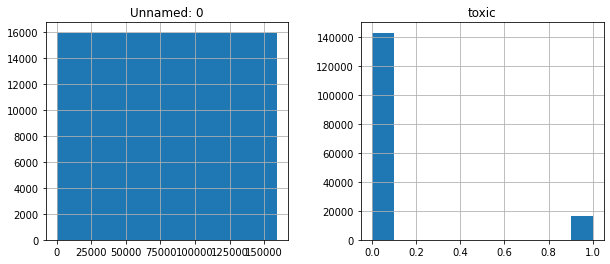

In [8]:
# Посмотрим информация по датасету
information(text)

В нашем датафрейме 159291 строка 3 столбца: *text* в нём содержит текст комментария, *toxic* — целевой признак для нашей модели (окраска комментария на положительный / отрицательный), и *Unnamed: 0* - скорее всего порядковый номер комментария, но, как можем заметить, максимальное значение данного столбца равно 159450, что не совпадает с максимальным значением индекса 159291, посмотрим подробнее.

Наименования столбцов соблюдены по правилам написания кода PEP8, за исключением *Unnamed: 0*. Явные дубликаты и пропуски данных отсутсвуют. Тип данных у столбцов корректный. Текст комментариев на английском, присутсвуют лишние знаки типа "\nMore\n".

Выборка у нас несбалансированная: примерно на 20 тыс положительных комментариев у нас приходится 140 тыс отрицательных.

**Проведем анализ и первичную предобработку**

In [9]:
# Для удобства работать будем в копии базы, что бы всегда можно что-то сравнить с оригиналом
# копию базы назовем 'data'
data = deepcopy(text)
text.sample(3)

,Unnamed: 0,text,toxic
56131,56192,REDIRECT Talk:Ali Salah Hashim,0
138157,138308,I am already registered but for anything relat...,0
52732,52789,"Look, stop messing up McMath Secondary School ...",0


In [10]:
# Проверим уникальный идентификатор на повторяющиеся значения
data['Unnamed: 0'].value_counts(ascending=False, dropna=False)

0        1
8913     1
64202    1
62155    1
51916    1
        ..
3371     1
13612    1
15661    1
9518     1
2047     1
Name: Unnamed: 0, Length: 159292, dtype: int64

Повторяющихся значений нет. Но данный столбец никакой пользы для обучение модели предсказания нам не даст, скорее может даже подзапутать, поэтому мы его удалим (поэтому и не переименовали название по правилам PEP8).

In [11]:
# удалим столбец
data = data.drop('Unnamed: 0', axis = 1)
data.sample(3)

,text,toxic
56412,"""\nIf you read the discussion above, the probl...",0
127474,"""\n\nI am unenthused about external generally....",0
54614,position abuse \n\nyou abuse you position and ...,1


0    143106
1     16186
Name: toxic, dtype: int64


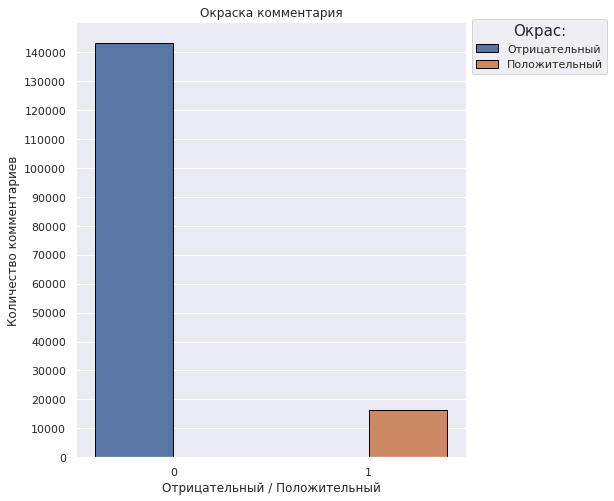

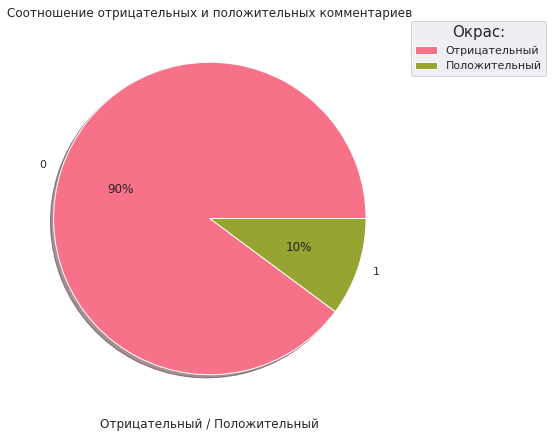

In [12]:
# toxic
# Посмотрим на целевой признак

print(data['toxic'].value_counts())

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(7,8)})
sns.countplot(data=data, x='toxic', ec='black', hue='toxic')
plt.title('Окраска комментария')
plt.xlabel('Отрицательный / Положительный')
plt.ylabel('Количество комментариев')
plt.yticks(ticks=np.arange(0,150000,10000))
legend = plt.legend(['Отрицательный', 'Положительный'], title = "Окрас:",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

# Посмотрим на круговую диаграмму
colors = sns.color_palette("husl", 4)
data.groupby(['toxic']).count().plot(kind='pie', y='text',
  autopct='%1.0f%%', colors=colors, shadow=True)
plt.title('Соотношение отрицательных и положительных комментариев')
plt.xlabel('Отрицательный / Положительный')
plt.ylabel('')
legend = plt.legend(['Отрицательный', 'Положительный'], title = "Окрас:",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

Только 16186 положительных комментариев, а это всего 10% от всего датафрейма. Выборка неравномерна.

Для баланса классов можно использовать разыне подходы (некоторые из них):
- Воспользоваться параметром `stratify` при разделении на выборки, а при обучении модели придать объектам редкого класса больший вес с помощью аргумента `class_weight`. Сделать веса классов сбалансированными.
- Использовать методы `upsampling` (Увеличение выборки) и `downsampling` (Уменьшение выборки). Смысл преобразования в следующем:
  - Разделяется обучающая выборка на отрицательные и положительные объекты;
  - Для `upsampling` копируются несколько раз положительные объекты. Для `downsampling` случайным образом отбросывается часть из отрицательных объектов;
  - С учётом полученных данных создается новая обучающая выборка;
  - Данные перемешиваются: идущие друг за другом одинаковые вопросы не помогут обучению, положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.
- или не использовать рукописные функции, а оптимизировать, используя *SMOTE* для увеличения выборки и *RandomUnderSampler* для уменьшения.


**Перейдем к обработке текста:**
- Очистим от лишних символов текст и стоп-слов, то есть слов без смысловой нагрузки
- Перед извлечением признаков из текста, лемматизируем его (приведение слова к начальной форме — лемме).

In [14]:
# напишем функцию по очистке текста. На вход она принимает текст, а возвращает очищенный текст, оставит только английские символы и пробелы.
def clear_text(text):
    text = text.lower()
    list_clear = re.sub(r'[^a-zA-Z]', ' ', text)   
    text_clear = ' '.join(list_clear.split())
    return text_clear

In [15]:
%%time

data['lemm_text'] = data['text'].apply(clear_text)
data.sample(5)

CPU times: user 4.46 s, sys: 40.3 ms, total: 4.5 s
Wall time: 4.51 s


,text,toxic,lemm_text
25405,Your opinion of why a non-custodial parent doe...,0,your opinion of why a non custodial parent doe...
95184,"This page duplicates Man Of Aran. Which goes, ...",0,this page duplicates man of aran which goes wh...
108664,I am mystified why the wrong user name keeps p...,0,i am mystified why the wrong user name keeps p...
80257,"You're right, Doc. I shouldn't have gotten in...",0,you re right doc i shouldn t have gotten involved
122756,them. That should be very clear to any admin w...,0,them that should be very clear to any admin wh...


In [16]:
# Напишим функцию лемматизации. На вход она принимает текст из корпуса и возвращает лемматизированную строку.
def lemmatize(text):
    lemm_text = " ".join([token.lemma_ for token in nlp(text)])
    return lemm_text

In [17]:
%%time

data['lemm_text'] = data['lemm_text'].apply(lemmatize)
data.sample(5)

CPU times: user 17min, sys: 10.5 s, total: 17min 11s
Wall time: 17min 11s


,text,toxic,lemm_text
154956,Related pages:\n\nJames Allen Williamson (Sena...,0,relate page james allen williamson senator all...
11632,I do think it's pretty important to include in...,0,I do think it s pretty important to include in...
127690,"""To AEuSoes1 - Your user page indicates that y...",0,to aeusoe your user page indicate that you be ...
55358,The intro does so much semantic dancing that I...,0,the intro do so much semantic dancing that I d...
55450,"""\n\n Precious \n\nmusic in South Africa\nThan...",0,precious music in south africa thank you for q...


**Разделим данные на обучающую и тестовую выборки.**

Разделим датафрейм на 3 выборки: обучающая(80% датафрейма) и валидационная(10% датафрейма), на них подберем и проверим лучшие гиперпараметры, затем на их объединной мощности обучим лучшую модель и измерим финальное качество модели на тестовой выборке (10% датафрейма). 

In [19]:
#  Обучающая выборка
features_train, features_test, target_train, target_test = train_test_split(
    data['lemm_text'].values, data['toxic'].values, test_size=0.2, random_state=STATE, stratify=data['toxic'])

# Векторизуем
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
features_train = count_tf_idf.fit_transform(features_train)

# Смотрим размер выборки 
print('Размер обучающей выборки:\n', features_train.shape, '\n', target_train.shape)
print('')
print('Размер тестовой  выборки:\n', features_test.shape, '\n', target_test.shape)

Размер обучающей выборки:
 (127433, 132996) 
 (127433,)

Размер тестовой  выборки:
 (31859,) 
 (31859,)


In [20]:
#  Валидационная и обучающая выборки

features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=STATE, stratify=target_test)

# Векторизуем
features_valid = count_tf_idf.transform(features_valid)
features_test = count_tf_idf.transform(features_test)

# Смотрим размер выборки 
print('Размер обучающей выборки:\n', features_valid.shape, '\n', target_valid.shape)
print('')
print('Размер валидационной  выборки:\n', features_test.shape, '\n', target_test.shape)

Размер обучающей выборки:
 (15929, 132996) 
 (15929,)

Размер валидационной  выборки:
 (15930, 132996) 
 (15930,)


Мы проанализировали и предобработали наш датафрейм:
- избавились от ненужного столбца;
- очистили наш текст от "грязи" и произвели лемматизацию.

Разбили данные на 3 выборки: 
- обучающая выборка с размером 127433;
- валидационная: 15929;
- тестовая: 15930.

## Обучение

Сбалансируем выборки и обучим наши модели.

Исследуем качество разных моделей, выберем оптимальные гиперпараметры. Метрикой качества будет выступать `F1-мера` (англ. F1-score). Это среднее гармоническое полноты и точности. Единица в F1 означает, что соотношение полноты и точности равно 1:1. 

В качестве моделей буем рассматривать:
- **CatBoost** 

Библиотека градиентного бустинга, созданная Яндексом. [CatBoost](https://catboost.ai/) - это алгоритм для повышения градиента на деревьях решений. Использует небрежные (oblivious) деревья решений, чтобы вырастить сбалансированное дерево. Одни и те же функции используются для создания левых и правых разделений (split) на каждом уровне дерева. Импортируем: `from catboost import CatBoostRegressor`

- **Cлучайный лес** (RandomForestClassifier)

Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования. Случайный лес помогает улучшить результат предсказания и избежать переобучения. В библиотеке sklearn алгоритм случайного леса RandomForestClassifier находится в модуле  sklearn.ensemble (от фр. «вместе»). Импортируем его:
`from sklearn.ensemble import RandomForestClassifier`

- **Логистическая регрессия** (LogisticRegression)

Логистическая регрессия применяется для прогнозирования вероятности возникновения некоторого события по значениям множества признаков.
Модель LogisticRegression лежит в модуле sklearn.linear_model (от англ. «линейная модель») библиотеки sklearn. Импортируем его:
`from sklearn.linear_model import LogisticRegression`

In [21]:
# Создадим таблицу результатов, куда будем заносить интересующую информацию
table = PrettyTable()
table.field_names = ['model','F1_train', 'F2_valid']
print(table)

+-------+----------+----------+
| model | F1_train | F2_valid |
+-------+----------+----------+
+-------+----------+----------+


 **RandomForestClassifier**

In [23]:
%%time

forest = RandomForestClassifier()
parameters = {'n_estimators': ([x for x in range(0, 110, 20)]),
              'max_depth': ([x for x in range(1, 11)]),
              'random_state': ([STATE]),
             'class_weight': (['balanced'])}

forest_cv = GridSearchCV(forest, parameters, scoring='f1', cv=3, n_jobs=-1)
forest_cv.fit(features_train, target_train)
print(f'Лучшие параметры RandomForestClassifier:')
forest_best_params = forest_cv.best_params_
print(forest_best_params)
print('')
forest_f1_train = forest_cv.best_score_
print(f'Значение метрики F1 на обучающей выборке {forest_f1_train}')

Лучшие параметры RandomForestClassifier:
{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100, 'random_state': RandomState(MT19937) at 0x7F4670E85B40}

Значение метрики F1 на обучающей выборке 0.3726505319190689
CPU times: user 18min 31s, sys: 4.69 s, total: 18min 36s
Wall time: 18min 36s


In [24]:
%%time

forest.set_params(**forest_best_params)
forest.fit(features_train, target_train)
forest_predict = forest.predict(features_valid)
forest_f1_valid = f1_score(target_valid, forest_predict)
print(f'Значение метрики F1 на валидационной выборке {forest_f1_valid}')
print('')
print('Матрица ошибок\n', confusion_matrix(target_valid, forest_predict))

Значение метрики F1 на валидационной выборке 0.35867293625914315

Матрица ошибок
 [[9646 4665]
 [ 245 1373]]
CPU times: user 5.15 s, sys: 20 ms, total: 5.17 s
Wall time: 5.18 s


In [25]:
# Вносим данные в таблицу
table.add_row(['RandomForestClassifier', forest_f1_train, forest_f1_valid])
print(table)

+------------------------+--------------------+---------------------+
|         model          |      F1_train      |       F2_valid      |
+------------------------+--------------------+---------------------+
| RandomForestClassifier | 0.3726505319190689 | 0.35867293625914315 |
+------------------------+--------------------+---------------------+


**LogisticRegression**

In [26]:
%%time

lr = LogisticRegression()

parameters = [{'solver':['newton-cg', 'lbfgs', 'liblinear'], 
               'C':[5, 10, 15],
               'random_state': ([STATE]),
               'class_weight':(['balanced']),
               'fit_intercept': ([True])}]

lr_cv = GridSearchCV(lr, parameters, scoring='f1', cv=3, n_jobs=-1)
lr_cv.fit(features_train, target_train)
print(f'Лучшие параметры LogisticRegression:')
lr_best_params = lr_cv.best_params_
print(lr_best_params)
print('')
lr_f1_train = lr_cv.best_score_
print(f'Значение метрики F1 на обучающей выборке {lr_f1_train}')

Лучшие параметры LogisticRegression:
{'C': 5, 'class_weight': 'balanced', 'fit_intercept': True, 'random_state': RandomState(MT19937) at 0x7F4670E85B40, 'solver': 'lbfgs'}

Значение метрики F1 на обучающей выборке 0.7653037260506018
CPU times: user 7min 3s, sys: 8min 2s, total: 15min 5s
Wall time: 15min 7s


In [27]:
%%time

lr.set_params(**lr_best_params)
lr.fit(features_train, target_train)
lr_predict = lr.predict(features_valid)
lr_f1_valid = f1_score(target_valid, lr_predict)
print(f'Значение метрики F1 на валидационной выборке {lr_f1_valid}')
print('')
print('Матрица ошибок\n', confusion_matrix(target_valid, lr_predict))

Значение метрики F1 на валидационной выборке 0.7697072072072072

Матрица ошибок
 [[13744   567]
 [  251  1367]]
CPU times: user 22.3 s, sys: 26.8 s, total: 49.1 s
Wall time: 49.3 s


In [28]:
# Вносим данные в таблицу
table.add_row(['LogisticRegression', lr_f1_train, lr_f1_valid])
print(table)

+------------------------+--------------------+---------------------+
|         model          |      F1_train      |       F2_valid      |
+------------------------+--------------------+---------------------+
| RandomForestClassifier | 0.3726505319190689 | 0.35867293625914315 |
|   LogisticRegression   | 0.7653037260506018 |  0.7697072072072072 |
+------------------------+--------------------+---------------------+


**CatBoostClassifier**

In [29]:
%%time

best_model = None
best_f1 = 0 

for depth in range (1,6):
    cat = CatBoostClassifier( # подбираем гиперпараметры
        n_estimators = 250, # кол-во эпох
        depth = depth, # глубина 
        learning_rate=0.2, # шаг обучения
        auto_class_weights='Balanced',
        eval_metric='F1',
        verbose=False
    ) 
    cat.fit(
    features_train, target_train, # передаем обучающую выборку
    plot=False # график
    )
    # получим предсказания модели на обучающей выборке
    cat_predicted_train = cat.predict(features_train)
    f1_cat_tr = f1_score(target_train, cat_predicted_train)
    # получим предсказания модели на валидационной выборке
    cat_predicted = cat.predict(features_valid)
    #  Посчитаем значение метрики на валидационной выборке
    f1_cat_valid = f1_score(target_valid, cat_predicted)
    print(f" best_depth = {depth}, f1_train = {f1_cat_tr}, f1_valid = {f1_cat_valid}")
    if f1_cat_valid >= best_f1:
            best_depth = depth # сохраним наилучшее показание глубины дерева
            best_model = cat # сохраним наилучшую модель
            best_f1 = f1_cat_valid # сохраним наилучшее значение f1
            f1_cat_train = f1_cat_tr
            
best_f1_cat = best_f1
print('')
print(f'Лучшее значение F1 для CatBoostClassifier при глубине {best_depth}') 
print(f'Значение метрики F1 на обучающей выборке: {f1_cat_train}')
print(f'Значение метрики F1 на валидационной выборке {best_f1_cat}')
print('')
print('Матрица ошибок\n', confusion_matrix(target_valid, cat_predicted))

In [33]:
%%time

#обучение:
cat = CatBoostClassifier(
        depth = 5,
        iterations = 10000,
        learning_rate=0.3,
        metric_period=200,
        od_type='Iter',
        od_wait=50,
        auto_class_weights='Balanced',
        eval_metric='F1',
    ) 
cat.fit(
    features_train, target_train,
    eval_set=(features_valid, target_valid),
    plot=True 
    )

cat_predict_train = cat.predict(features_train)
cat_f1_train = f1_score(target_train, cat_predict_train)
print(f'Значение метрики F1 на обучающей выборке {cat_f1_train}')    
cat_predict = cat.predict(features_valid)
cat_f1_valid = f1_score(target_valid, cat_predict)
print(f'Значение метрики F1 на валидационной выборке {cat_f1_valid}')
print('')
print('Матрица ошибок\n', confusion_matrix(target_valid, cat_predict))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4834875	test: 0.4671029	best: 0.4671029 (0)	total: 2.12s	remaining: 5h 53m 1s
200:	learn: 0.9225384	test: 0.8913595	best: 0.8913595 (200)	total: 5m 6s	remaining: 4h 8m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8930790565
bestIteration = 232

Shrink model to first 233 iterations.
Значение метрики F1 на обучающей выборке 0.8003441156228494
Значение метрики F1 на валидационной выборке 0.7586399108138238

Матрица ошибок
 [[13702   609]
 [  257  1361]]
CPU times: user 7min 42s, sys: 4.75 s, total: 7min 47s
Wall time: 7min 49s


In [34]:
# Вносим данные в таблицу
table.add_row(['CatBoostClassifier', cat_f1_train, cat_f1_valid])
print(table)

+------------------------+--------------------+---------------------+
|         model          |      F1_train      |       F2_valid      |
+------------------------+--------------------+---------------------+
| RandomForestClassifier | 0.3726505319190689 | 0.35867293625914315 |
|   LogisticRegression   | 0.7653037260506018 |  0.7697072072072072 |
|   CatBoostClassifier   | 0.8003441156228494 |  0.7586399108138238 |
+------------------------+--------------------+---------------------+


AUC-ROC RandomForestClassifier: 0.8797222982070808

AUC-ROC LogisticRegression: 0.9699250034484697

AUC-ROC CatBoostClassifier: 0.9638577048660952


<Figure size 504x576 with 0 Axes>

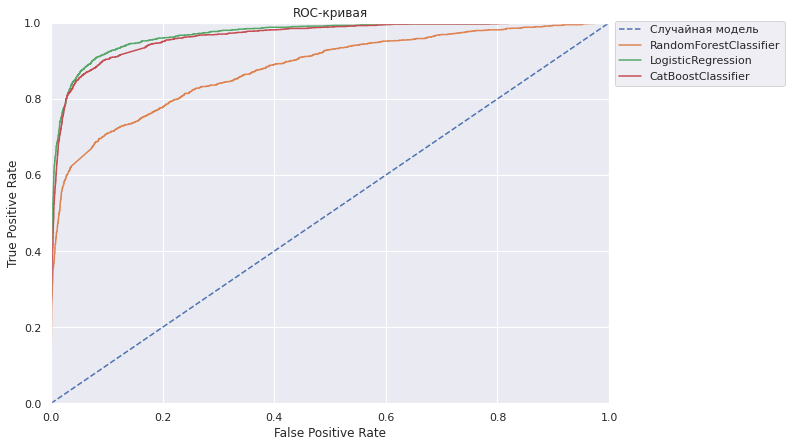

In [35]:
# Построим ROC-кривую и изобразим её на графике и посчитаем AUC-ROC

# ROC-кривая RandomForestClassifier
fpr_forest, tpr_forest, thresholds = roc_curve(target_valid,
                                         forest.predict_proba(features_valid)[:, 1])

forest_roc = roc_auc_score(target_valid, forest.predict_proba(features_valid)[:, 1])
print('AUC-ROC RandomForestClassifier:', forest_roc)
print('')

# ROC-кривая LogisticRegression
fpr_lr, tpr_lr, thresholds = roc_curve(target_valid, lr.predict_proba(features_valid)[:, 1])

lr_roc = roc_auc_score(target_valid, lr.predict_proba(features_valid)[:, 1])
print('AUC-ROC LogisticRegression:', lr_roc)
print('')

# ROC-кривая CatBoostClassifier
fpr_cat, tpr_cat, thresholds = roc_curve(target_valid, cat.predict_proba(features_valid)[:, 1])

cat_roc = roc_auc_score(target_valid, cat.predict_proba(features_valid)[:, 1])
print('AUC-ROC CatBoostClassifier:', cat_roc)

plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_forest,tpr_forest)
plt.plot(fpr_lr,tpr_lr)
plt.plot(fpr_cat,tpr_cat)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','RandomForestClassifier','LogisticRegression','CatBoostClassifier'),
           bbox_to_anchor=(1, 1.02), loc='upper left') 
plt.show()

Мы проверили 3 модели с подбором лучших гиперпараметров и может сделать следующие выводы:
- Лучше всех себя показа Логистическая регрессия с гиперпараметром - C = 5, сбалансированным весом и 'solver' = 'lbfgs'. Показатель метрики качества F1 равен 0.77
- на втором месте яндексовский классификатор с результатом F1 на валидационной выборке ~0.76, при глубине = 5, 233 итерации, сбалансированным весом и шагом обучения 0,3.
- худшая модель "Решающий лес" с результатом 0,36. Даже долгое обучение по поиску лучших гиперпараметров не помогло добиться лучших результатов.

Можно предположить, что для распознования оценки негативности текста лучше подходит линейная модель, чем дерево решений, даже с учетом бустинга. 

Хоть в целом отставание CatBoost от LogisticRegression всего 1 сотая на валидационной выборке, но мы видим на матрице ошибок, что логистическая регрессия предсказывает меньше False (как False Negative, так и False Positive) ответов, так и больше правильных прогнозов. Что нам и показывает ROC-кривая (По горизонтали доля ложноположительных ответов (FPR), а по вертикали — доля истинно положительных ответов (TPR)). AUC-ROC (от англ. Area Under Curve ROC, «площадь под ROC-кривой») - у LogisticRegression: 0.969, а у CatBoostClassifier: 0.963. При этом и время обучения логистической модели было быстрее. 

## Выводы

Так как модель **LogisticRegression** показало лучшие результаты с результатами F1 на обучающей выборке 0.7653037260506018, **F1 на валидационной выборке 0.7697072072072072**, при параметрах *'C': 5, 'class_weight': 'balanced', 'fit_intercept': True, 'solver': 'lbfgs'*, то финальное тестирование будем проводить на данной модели на объединненой выборке (target + valid) в попытке немного улучшить качество нашей модели.

In [36]:
%%time

# Используем лучшие гиперпараметры

lr.set_params(**lr_best_params)
lr.fit(features_train, target_train)
final_predict = lr.predict(features_test)
lr_f1_final = f1_score(target_test, final_predict)
print(f'Значение метрики F1 на тестовой выборке {lr_f1_final} для LogisticRegression')
print('')
print('Матрица ошибок\n', confusion_matrix(target_test, final_predict))

Значение метрики F1 на тестовой выборке 0.7776847977684798 для LogisticRegression

Матрица ошибок
 [[13739   572]
 [  225  1394]]
CPU times: user 22.2 s, sys: 27.2 s, total: 49.3 s
Wall time: 49.4 s


AUC-ROC на валидационной выборке: 0.9699250034484697

AUC-ROC на тестовой выборке: 0.9731936486008399



<Figure size 504x576 with 0 Axes>

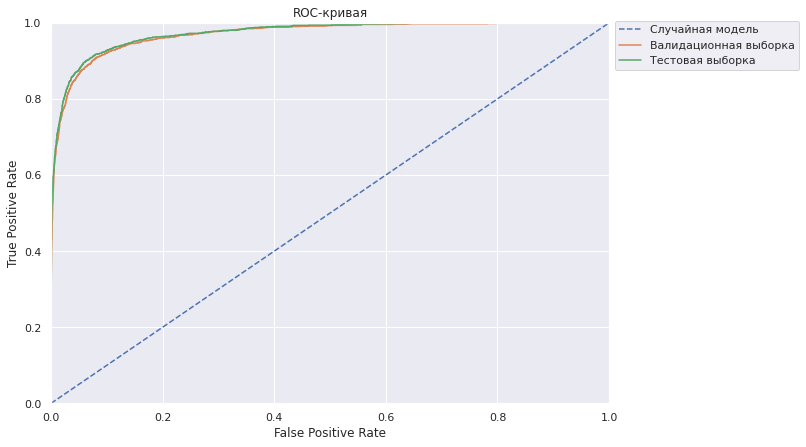

In [37]:
# Построим ROC-кривую

# ROC-кривая для валидации
fpr_valid, tpr_valid, thresholds = roc_curve(target_valid,
                                         lr.predict_proba(features_valid)[:, 1])

valid_roc = roc_auc_score(target_valid, lr.predict_proba(features_valid)[:, 1])
print('AUC-ROC на валидационной выборке:', valid_roc)
print('')

# ROC-кривая для теста
fpr_test, tpr_test, thresholds = roc_curve(target_test, lr.predict_proba(features_test)[:, 1])

test_roc = roc_auc_score(target_test, lr.predict_proba(features_test)[:, 1])
print('AUC-ROC на тестовой выборке:', test_roc)
print('')

plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_valid,tpr_valid)
plt.plot(fpr_test,tpr_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Валидационная выборка','Тестовая выборка'),
           bbox_to_anchor=(1, 1.02), loc='upper left') 
plt.show()

In [38]:
# Проверим модель на адекватность

dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
f1_dummy = f1_score(dummy_model.predict(features_test), target_test)
print(f'Лучшее значние F1 DummyClassifier {f1_dummy} ')

Лучшее значние F1 DummyClassifier 0.18451193800216537 


**Вывод:**

Для интернет-магазина «Викишоп», мы разработали модель, которая поможет запустить новый сервис и классифицировать комментарии на позитивные и негативные, модель будет искать токсичные комментарии и отправлять их на модерацию.

С помощью предоставленного набора данных с разметкой о токсичности правок, мы смогли проанализировать и предобработать датафрейм. В нем было 159291 комментариев, из которых только 10% положительных. С помощью лемметизации, очистки текста от лишних символов и стоп-слов, а так же балансировки классов мы сравнили три модели обучения. Для этого мы разделили наш датафрейм на три выборки. На первой выборке обучали модели, на валидационной подбирали лучшие гиперпараметры и проверяли качество метрики - F1-мера, это среднее гармоническое полноты и точности. Посмотрели моедли: CatBoost, RandomForestClassifier, LogisticRegression.

Лучшей моделью оказалась **LogisticRegression**, со значением метрики качества F1 на тестовой выборке равной **0,777**. Таким образом выполнили поставленную задачу: Постройть модель со значением метрики качества F1 не меньше 0.75. Проверили модель на адекватность. F1 модели DummyClassifier равна 0.18, что в разы хуже проверенных нами моделей. Это говорит нам о том, что модель машинного обучения лучше предсказывает, чем постоянная модели, предсказывающее положительные комментарии.

Уровень AUC-ROC нашей модели на тестовой выборке: 0.97, что весьма неплохой результат. А матрица ошибок показывает, что на 13739 True Negative ответа у нас только 572 False Positiv, а на 1394 True Positiv ответа только 225 False Negative.